# Pop Music Through the Ages: A CNN Model of Spectrograms

The objective of this project is to build a model that classifies songs from the Billboard Top 100 by decade.  By then analyzing how the model performs on different songs, we can make a lot of interesting insights about music history and how pop music has changed throughout time.  To achieve this, I have used a convolutional neural network trained on spectograms obtained from 5 second clips from the middle of each song.  A spectrogram is a visual representation of the spectrum of sound frequencies.  By creating a "picture" of the sound, we are now able to take advantage of the power of convolutional neural networks, a method used in image classification. This model achieves an accuracy of 48% for identifying the correct decade and an accuracy of 85% for identifying plus or minus one decade.  (As a point of reference, if the model classified randomly, it would have an accuracy of 14% and an accuracy of 39% for identifying plus or minus one decade.)

From this model, I've made some pretty cool insights about pop music through the ages.  Here are a few highlights:

* Some songs that really exemplified their eras were:
    * "It's Too Late" by Carole King (from the 1970s)
    * "Jack and Diane" by John Mellencamp (from the 1980s)
    * "Return of the Mack" by Mark Morrison (from the 1990s)
* One songs that may be ahead of its time is:
    * "Hey Jude" by the Beatles (from the 1960s and classified as the 1990s)
* Some songs that may feel "retro" are:
    * "So Hard To Say Goodbye" by Boyz 2 Men (from the 1990s and classified as the 1960s)
    * "Love Yourself" by Justin Beiber (from the 2010s and classified as the 1960s)
    * "Goodbye, England's Rose" by Elton John (from the 1990s and classified as the 1970s)
* 1960s music was easiest to classify correctly, suggesting it may be the most distinctive music era.  


## Implementation

For this project, I used librosa for audio processing and keras for the convolutional neural networks.

In [1]:
%matplotlib inline
import librosa
from librosa.display import specshow
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn
import IPython.display as ipd
import h5py as h5py

Using TensorFlow backend.


The dataset I used is a collection of the mp3 files of all of the Billboard Top 100 Lists from 1955 to 2016.  This dataset was obtained by first crawling the website playback.fm, which has these lists along with the associated youtube links, and then using youtube-dl to grab snippets of each song.

In [2]:
music_files = sorted(glob.glob('/Users/edatta/Desktop/MUSICZ/*/*.mp3'))

Spectrograms are visual representations of songs that show the intensity of sound frequencies over time.  The mel scale is a perceptual scale of pitch, so we use this scale for our spectrogram so it matches how humans perceive music.  We also take the log amplitude of the spectrogram since the human perception of sound intensity is logarithmic in nature.

In [3]:
if os.path.exists('LogSpectograms.npy'):
    X = np.load('LogSpectograms.npy')

else:
    X = []
    for i,music_file in enumerate(music_files):
        
        # Load mp3
        audio_time_series, sampling_rate = librosa.load(music_file)
    
        # Get middle ~5 seconds of song
        length = len(audio_time_series)
        middle_index = int(length/2)
        song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    
        # Calculate log spectrogram
        spectrogram = librosa.feature.melspectrogram(song_middle, sampling_rate)
        log_spectrogram = librosa.logamplitude(spectrogram)
        X.append(log_spectrogram)
        
    np.save('LogSpectograms.npy', np.asarray(X))

We can visualize these log mel-scaled spectrograms to get an idea of how they may differ according to song.  Below, we see a comparison of the log spectrogram image from clips from two very different songs, "The Twist" (the number one song from 1962) and "In Da Club" (the number one song from 2003). 

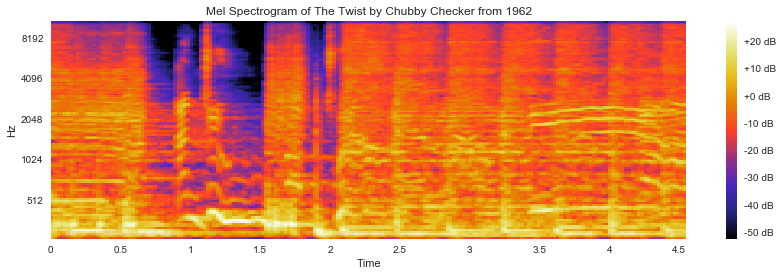

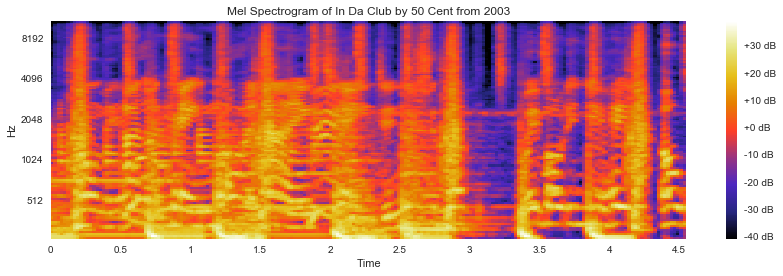

In [4]:
song_indices = [3284,7384]

for i,index in enumerate(song_indices):
    filename = music_files[index]
    parts = filename.split('_')
    song = parts[1]
    artist = parts[2].split('.')[0]
    yr = os.path.basename(os.path.dirname(filename))
    
    logS = X[index,:,:]
    plt.figure(figsize=(12,4))
    specshow(logS, cmap='CMRmap',x_axis='time', y_axis='mel')
    plt.title('Mel Spectrogram of '+song+' by '+artist+' from '+yr)
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()
    
    audio_time_series, sampling_rate = librosa.load(filename)
    length = len(audio_time_series)
    middle_index = int(length/2)
    song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    
    ipd.display(ipd.Audio(song_middle, rate=sampling_rate))
    plt.show()

For use in the convolutional neural network, it is necessary to normalize the input array and reshape the array.

In [6]:
# Normalize intensities to range [0,1] and save as floats
X = np.asarray(X)
max_value = np.amax(X)
X = X.astype('float32')
X = X/max_value

#img_means = np.mean(X,axis=(1,2))
#broadcast_img_means = img_means[:,np.newaxis, np.newaxis]
#img_stds = np.std(X,axis=(1,2))
#broadcast_img_stds = img_stds[:,np.newaxis, np.newaxis]
#normalize_X = np.subtract(X,broadcast_img_means)
#normalize_X = np.divide(normalize_X,broadcast_img_stds)
#X = normalize_X

# Reshape X so there is an extra batch dimension (at the beginning for use with TensorFlow backend)
img_rows = X.shape[1]
img_cols = X.shape[2]
if K.image_data_format() == 'channels_first':
    shape = (1, img_rows, img_cols)
else:  # channel_last
    shape = (img_rows, img_cols, 1)
X = X.reshape((X.shape[0],) + shape)

For the outputs, I obtain the decade for each of the music files.  For use in the convolutional neural network, I've encoded the outputs in a one hot array.  The function "get_Y_decade" is defined so that it is easy to convert easily from the one hot array back to the decade.  

In [7]:
if os.path.exists('Y_decade.npy'):
    Y = np.load('Y_decade.npy')
else:
    Y = []
    for i,music_file in enumerate(music_files):
        decade = (int(os.path.basename(os.path.dirname(music_file)))-1900)/10
        Y.append(decade)
    Y = np.asarray(Y)
    unique_values = np.unique(Y)
    Y = np_utils.to_categorical(Y,len(unique_values))
    Y = Y.astype(int)
    np.save('Y_decade.npy', Y_decade)  
    
def get_Y_decade(Y):
    Y_decade = np.argmax(Y,axis=1)
    Y_decade = (Y_decade*10)+1950
    return Y_decade

My data set includes music from 1900 to present day, but since the lists from earlier years are shorter and the music clips from earlier years are of worse quality, I will extract only the music files from the Billboard Top 100 charts (1955-present).

In [8]:
# Only use music files from the Billboard Top 100 charts (1955-present) 
music_files = music_files[2643:]
X = X[2643:,:,:,:] 
Y = Y[2643:,5:] 
np.save('Billboard_LogSpectograms.npy', np.asarray(X))

Then, I delete any duplicates for any song that was on the Billboard charts in more than one year.

In [9]:
music_files_wo_years = [os.path.basename(filename).split('_')[1]+'_'+os.path.basename(filename).split('_')[2] for filename in music_files]

seen_files = set()
unique_files = []
unique_spectrograms = []
unique_years = []
for i, music_file in enumerate(music_files_wo_years):
    music_file_w_year = music_files[i]
    spectrogram = X[i,:,:,:]
    year = Y[i,:]
    if music_file not in seen_files:
        unique_files.append(music_file_w_year)
        unique_spectrograms.append(spectrogram)
        unique_years.append(year)
        seen_files.add(music_file)
music_files = unique_files
X = np.asarray(unique_spectrograms)
Y = np.asarray(unique_years)

Then I split the data into training, validation, and test sets.

In [10]:
# Use the top 10 songs from each year as the test set (10% of the available data)
music_files_train = []
X_train = []
Y_train = []
music_files_test = []
X_test = []
Y_test = []

for i, music_file in enumerate(music_files):
    song_num = int(os.path.basename(music_file).split('_')[0])
    if song_num > 10:
        music_files_train.append(music_file)
        X_train.append(X[i,:,:,:])
        Y_train.append(Y[i,:])
    else:
        music_files_test.append(music_file)
        X_test.append(X[i,:,:,:])
        Y_test.append(Y[i,:])

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

# From the remaining data, split randomly into a training set and validation set (81% and 9% of data respectively)
X_train, X_valid, Y_train, Y_valid, music_files_train, music_files_valid = train_test_split(X_train,Y_train,music_files_train,test_size=.1)

Define the architecture of the convolutional neural network and train the model using cross validation.  The diagram below shows a similar architecture to the one I am using.  The model here has two convolutional layers, followed by a pooling layer.  The input is then flattened and there are two dense fully connected layers.  The output is obtained by using softmax to convert the probabilities into classes.  A rectifier (ReLu) function is used for activation.  Dropout layers randomly set certain input units to 0, which help prevent overfitting.
<img src="https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1506591535706.jpg">
(Diagram from https://www.mathworks.com/discovery/convolutional-neural-network.html)

In [11]:
nb_classes = Y_train.shape[1]
shape = (X_train.shape[1],X_train.shape[2],1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Now, train the model with cross validation.

In [12]:
weights_file = 'best_weights.hdf5'
if(os.path.exists(weights_file)):
    model.load_weights(weights_file)
else:
    checkpt = ModelCheckpoint(weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
    callbacks = [checkpt, early]
    hist = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, nb_epoch=20, verbose=1, shuffle=True, callbacks=callbacks)                        

Calculate the predicted decades and the probabilities used for prediction.  Also, calculate the accuracy of the model when evaluated on the test data.  48% of the songs were classified correctly and 85% of the songs were classified correctly within one decade.

In [13]:
model.load_weights(weights_file)
score = model.evaluate(X_test, Y_test, verbose=1)
Y_predict = model.predict(X_test)
Y_predict_proba = model.predict_proba(X_test)

Y_test_decade = get_Y_decade(Y_test)
Y_predict_decade = get_Y_decade(Y_predict)

acc = score[1]
deltas = np.abs(Y_test_decade - Y_predict_decade)
deltas_within_10 = deltas[deltas<=10]
acc_within_10 = len(deltas_within_10)/float(len(deltas))
print('ACCURACY:')
print(acc)
print('ACUURACY WITHIN ONE DECADE')
print(acc_within_10)

599/599 [==============================] - 12s    
ACCURACY:
0.489148580421
ACUURACY WITHIN ONE DECADE
0.858096828047


The confusion matrix below shows how the convolutional neural network performs and where most of the errors occur.  From this confusion matrix, we can see that most misclassifications were made plus or minus one decade, which makes sense since music styles don't change magically at the decade mark.

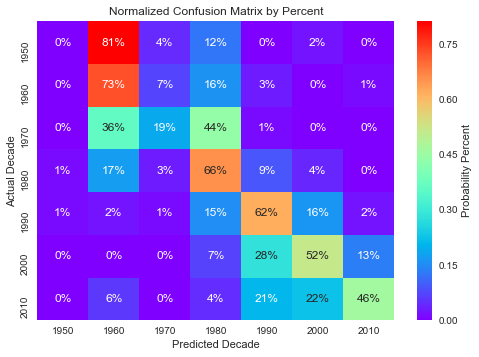

In [14]:
confusion = confusion_matrix(Y_test_decade, Y_predict_decade)
decades = np.unique(Y_test_decade).tolist()
confusion_df = pd.DataFrame(confusion, index=decades, columns=decades)

normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
normalized_confusion_df = pd.DataFrame(normalized_confusion, index=decades, columns=decades)
confusion_plt = seaborn.heatmap(normalized_confusion_df,cmap=cm.rainbow,cbar_kws={'label': 'Probability Percent'}, annot=True, fmt=".0%")
confusion_plt.set(xlabel='Predicted Decade', ylabel='Actual Decade')
confusion_plt.set_title('Normalized Confusion Matrix by Percent')
confusion_plt_fig = confusion_plt.get_figure()
confusion_plt_fig.savefig('Plot1_Confusion_Matrix.png')
plt.show()

### Let's now look at how the model performs on the whole data set to make some insights about songs!  

First, I'll print a table of the song that had the highest probability for each square in the confusion matrix.  The columns are the actual decades and the rows are the predicted decades.  The songs along the diagonal were the easiest to classify correctly and the other songs are the most egregious mistakes for that classification error.

In [15]:
music_files_test = np.asarray(music_files_test)
decades = np.unique(Y_test_decade).tolist()
target_df_list = []

for i, target in enumerate(decades):
    songnames = []
    artists = []
    probabilities = []
    
    for decade in decades:
        songs_from_decade = music_files_test[Y_test_decade == decade]
        predictions_for_songs_from_decade = Y_predict_decade[Y_test_decade == decade]
        probabilities_for_songs_from_decade = (np.asarray(Y_predict_proba))[Y_test_decade == decade,:]
        
        songs_classified_as_target = songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)]
        probabilities_for_songs_classified_as_target = np.squeeze(probabilities_for_songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)],axis=1)[:,i]
        
        if songs_classified_as_target.tolist():
            highest_probability_index = np.argmax(probabilities_for_songs_classified_as_target)
            highest_probability = probabilities_for_songs_classified_as_target[highest_probability_index]
            most_probable_song = songs_classified_as_target[highest_probability_index]
            
            songnames.append(os.path.basename(most_probable_song[0]).split('_')[1])
            artists.append(os.path.basename(most_probable_song[0]).split('_')[2].split('.')[0])
            probabilities.append(highest_probability)
        else:
            songnames.append('')
            artists.append('')
            probabilities.append(0)
        
    probabilities = [str(int(probability*100))+'%' for probability in probabilities] 
    target_df = pd.DataFrame(index=decades,columns=['Song','Artist','Prob'])
    target_df['Song'] = songnames
    target_df['Artist'] = artists
    target_df['Prob'] = probabilities
    target_df_list.append(target_df)
confusion_df = pd.concat(target_df_list, keys=decades, axis=1)    
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    ipd.display(confusion_df)

1950                                            1960  \
                        Song        Artist Prob                         Song   
1950                                        0%   Les Baxter                    
1960                                        0%   Theme From A Summer Place     
1970                                        0%   Take Me Home, Country Roads   
1980  Rose, The               Bette Midler  40%  Coming Up                     
1990  So Hard To Say Goodbye  Boyz II Men   31%  Goodbye, England's Rose       
2000                                        0%                                 
2010                                        0%   Me, Myself & I                

                                                      1970  \
                Artist Prob                           Song   
1950  Unchained Melody  78%  Don't Forbid Me                 
1960  Percy Faith       83%  I'll Never Fall In Love Again   
1970  John Denver       76%  It's Too Late                   
1980  Paul McCartney    71%  Sweet Child O' Mine             
1990  Elton John        50%  Heartbreak Hotel                
2000                    0%                                   
2010  G-Eazy            63%                                  

                                                          1980  \
                             Artist Prob                  Song   
1950  Pat Boone                      38%  Patricia               
1960  Tom Jones                      45%  A Hard Days Night      
1970  Carole King                    56%  Boogie Oogie Oogie     
1980  Guns N' Roses                  53%  Jack & Diane           
1990  Whitney Houston & Faith Evans  24%  Nothing Compares 2 U   
2000                                 0%   You're Beautiful       
2010                                 0%   The Monster            

                                             1990                          \
                Artist Prob                  Song                  Artist   
1950  Perez Prado       54%                                                 
1960  Beatles           71%  Good Lovin'           The Young Rascals        
1970  A Taste Of Honey  86%  My Love               Paul McCartney & Wings   
1980  John Mellencamp   83%  Blame It On The Rain  Milli Vanilli            
1990  Sinead O'Connor   78%  Return Of The Mack    Mark Morrison            
2000  James Blunt       62%  Check On It           Beyonce Ft Slim Thug     
2010  Eminem            54%  Counting Stars        OneRepublic              

                                2000                         \
     Prob                       Song            Artist Prob   
1950  0%   All I Have To Do Is Dream  Everly Brothers   36%   
1960  44%                                               0%    
1970  37%                                               0%    
1980  78%  Wind Beneath My Wings      Bette Midler      49%   
1990  82%  Baby Got Back              Sir Mix A Lot     63%   
2000  69%  No One                     Alicia Keys       79%   
2010  66%  Call Me Maybe              Carly Rae Jepsen  67%   

                         2010                                
                         Song                   Artist Prob  
1950                                                    0%   
1960  I Can't Stop Loving You  Ray Charles              24%  
1970                                                    0%   
1980                                                    0%   
1990  Jump                     Kris Kross               64%  
2000  The Way You Move         Outkast Ft Sleepy Brown  83%  
2010  The Hills                The Weeknd               87%

The plot below shows how the probabilities were distributed for each of the songs in the chart above.

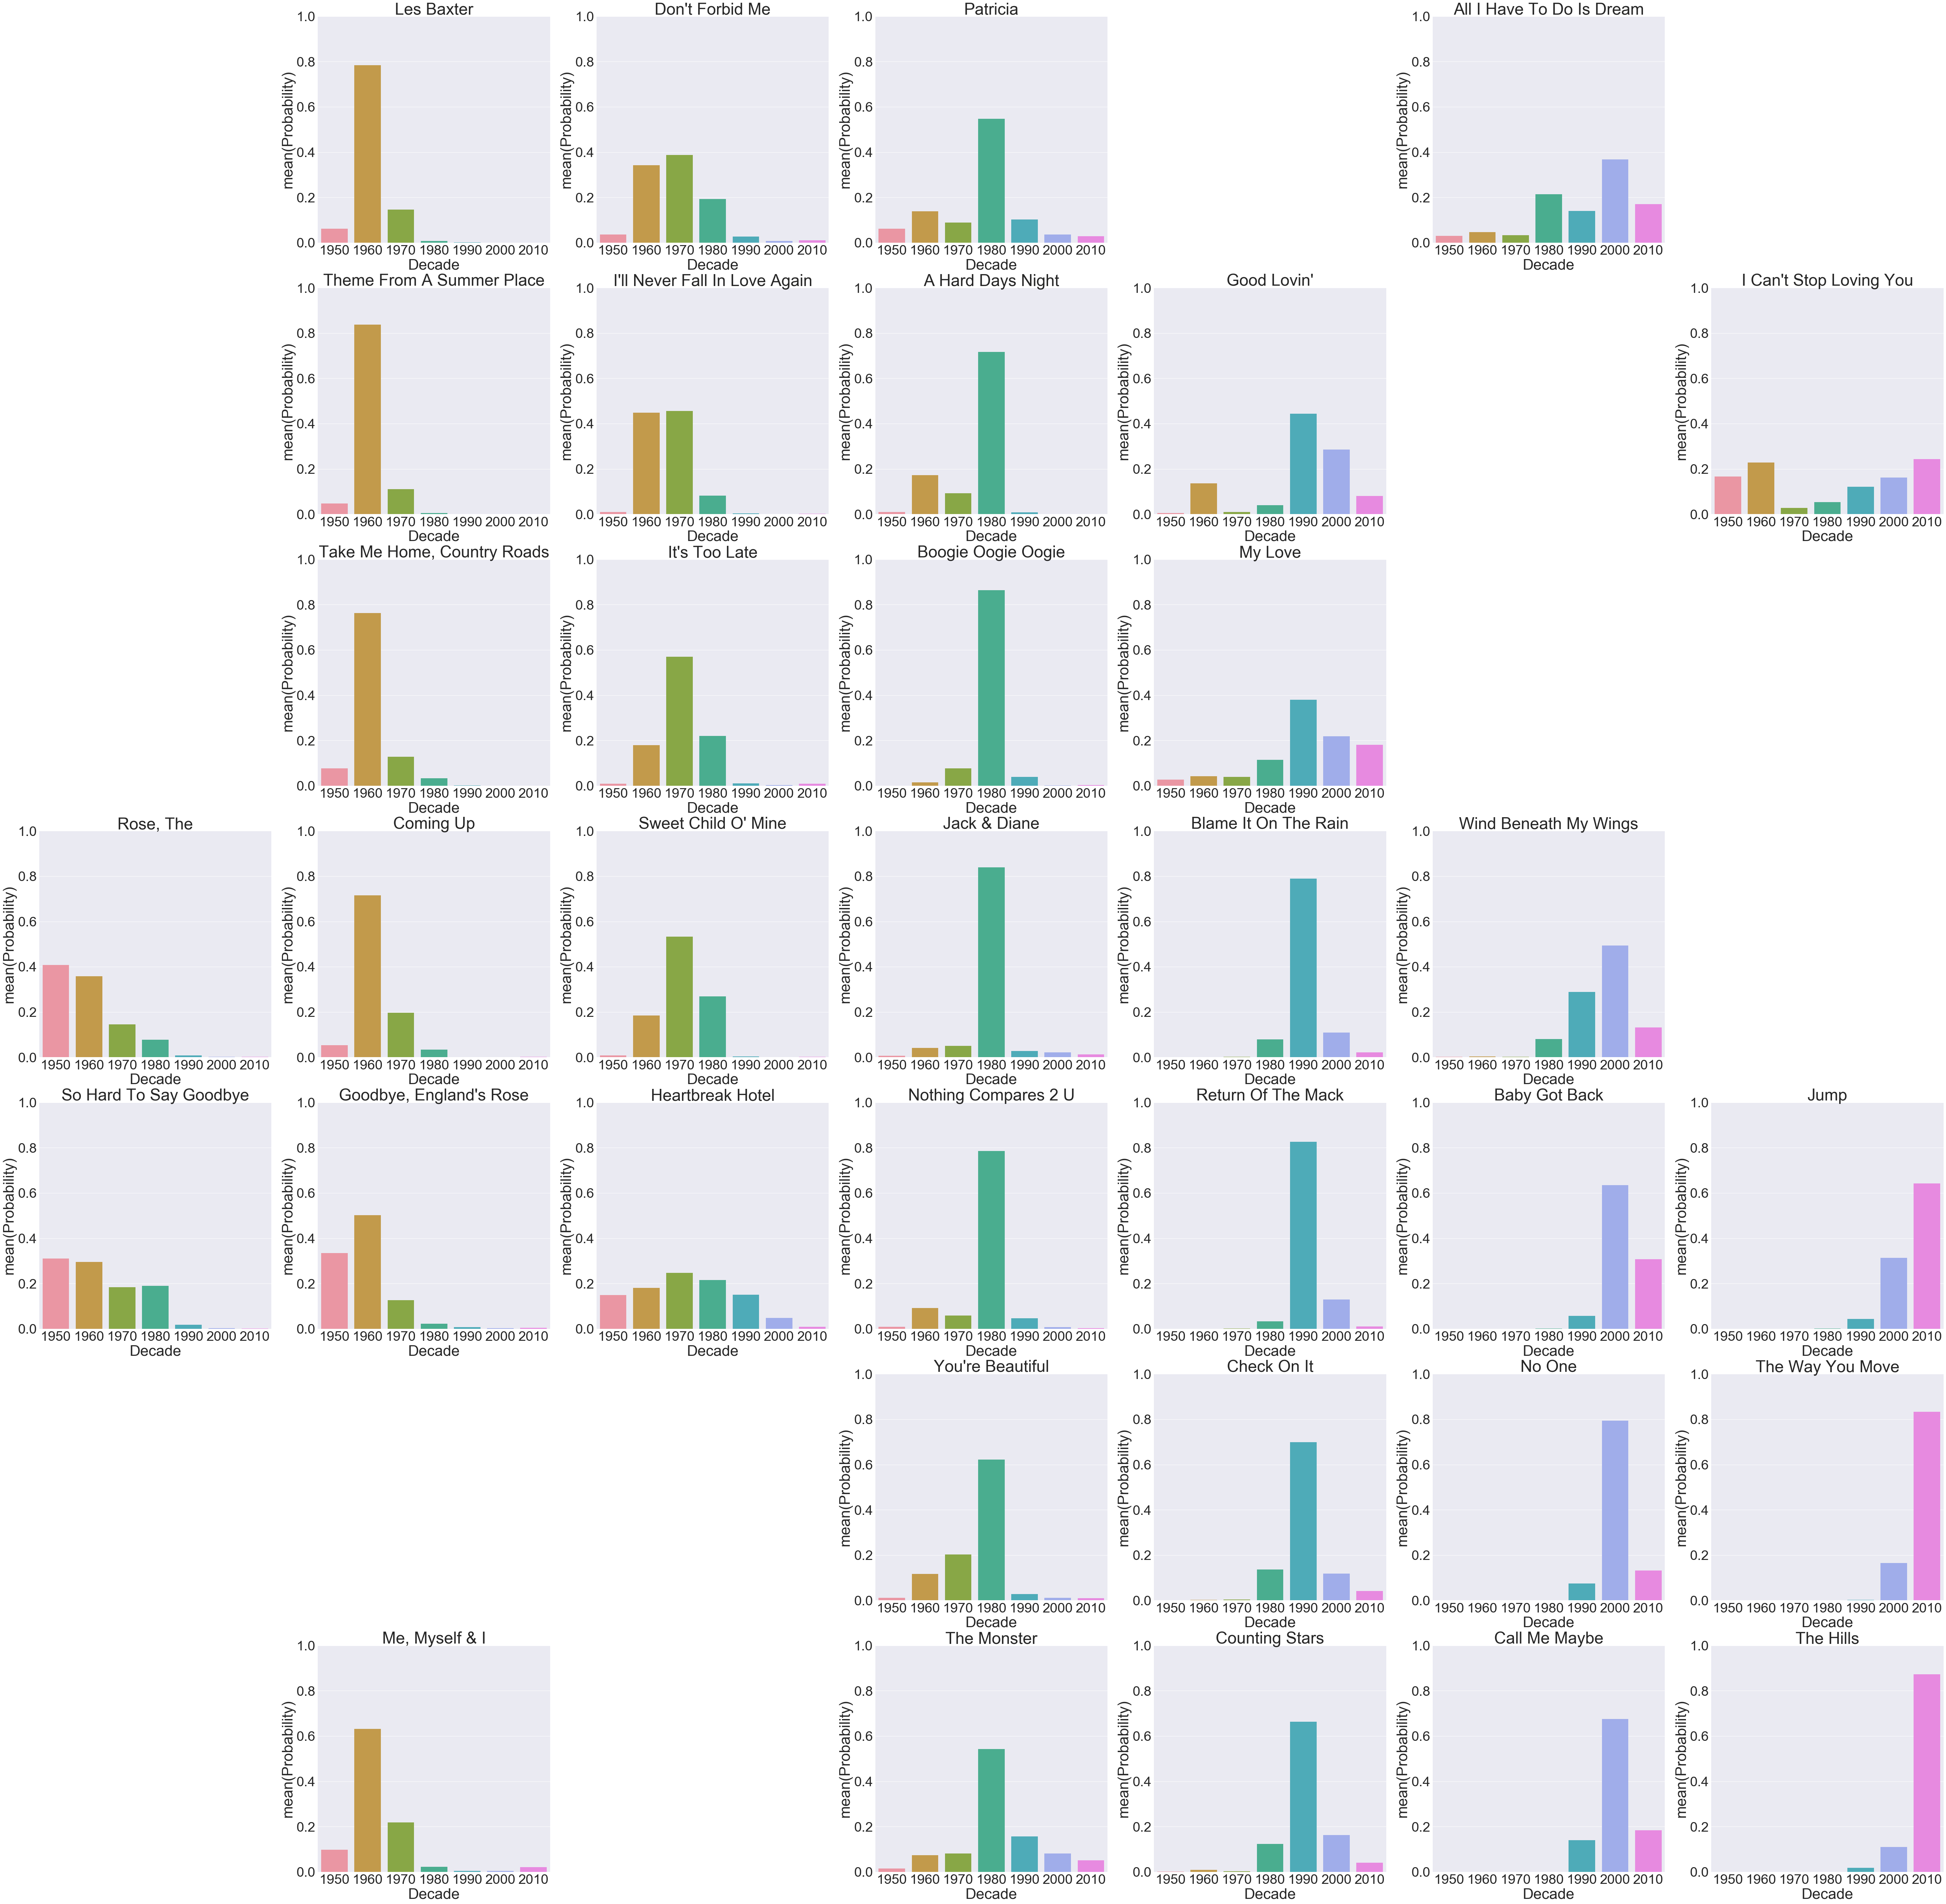

In [16]:
music_files_test = np.asarray(music_files_test)
decades = np.unique(Y_test_decade).tolist()
target_df_list = []

fig = plt.figure(figsize=(100, 100))
seaborn.set(font_scale=4)
for i, target in enumerate(decades):
    songnames = []
    artists = []
    probabilities = []
    
    for j,decade in enumerate(decades):
        songs_from_decade = music_files_test[Y_test_decade == decade]
        predictions_for_songs_from_decade = Y_predict_decade[Y_test_decade == decade]
        probabilities_for_songs_from_decade = (np.asarray(Y_predict_proba))[Y_test_decade == decade,:]
        
        songs_classified_as_target = songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)]
        probabilities_for_songs_classified_as_target = np.squeeze(probabilities_for_songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)],axis=1)[:,i]
        all_probabilities_for_songs_classified_as_target = np.squeeze(probabilities_for_songs_from_decade[np.argwhere(predictions_for_songs_from_decade == target)],axis=1)
        
        if songs_classified_as_target.tolist():
            highest_probability_index = np.argmax(probabilities_for_songs_classified_as_target)
            highest_probability = probabilities_for_songs_classified_as_target[highest_probability_index]
            most_probable_song = songs_classified_as_target[highest_probability_index]
            most_probable_song_probabilities = all_probabilities_for_songs_classified_as_target[highest_probability_index]
            
            songnames.append(os.path.basename(most_probable_song[0]).split('_')[1])
            artists.append(os.path.basename(most_probable_song[0]).split('_')[2].split('.')[0])
            probabilities.append(highest_probability)
            
            ax = fig.add_subplot(7,7,(j*7)+i+1)
            dictionary = {'Decade':np.asarray(decades), 'Probability':np.asarray(most_probable_song_probabilities)}
            df = pd.DataFrame()
            df = df.from_dict(dictionary)
            barplot = seaborn.barplot(x='Decade', y='Probability', data=df, ax=ax)
            axes = barplot.axes
            axes.set_ylim(0,1)
            axes.set_title((most_probable_song[0]).split('_')[1])
        else:
            songnames.append('')
            artists.append('')
            probabilities.append(0)

Now let's take a look at the classification probabilities for all of the songs from the 1990s and see which songs the model got correct and which songs the model was most confused by.  The heatmap below shows the full list of songs and is brightest when the probabilities were high for that decade.

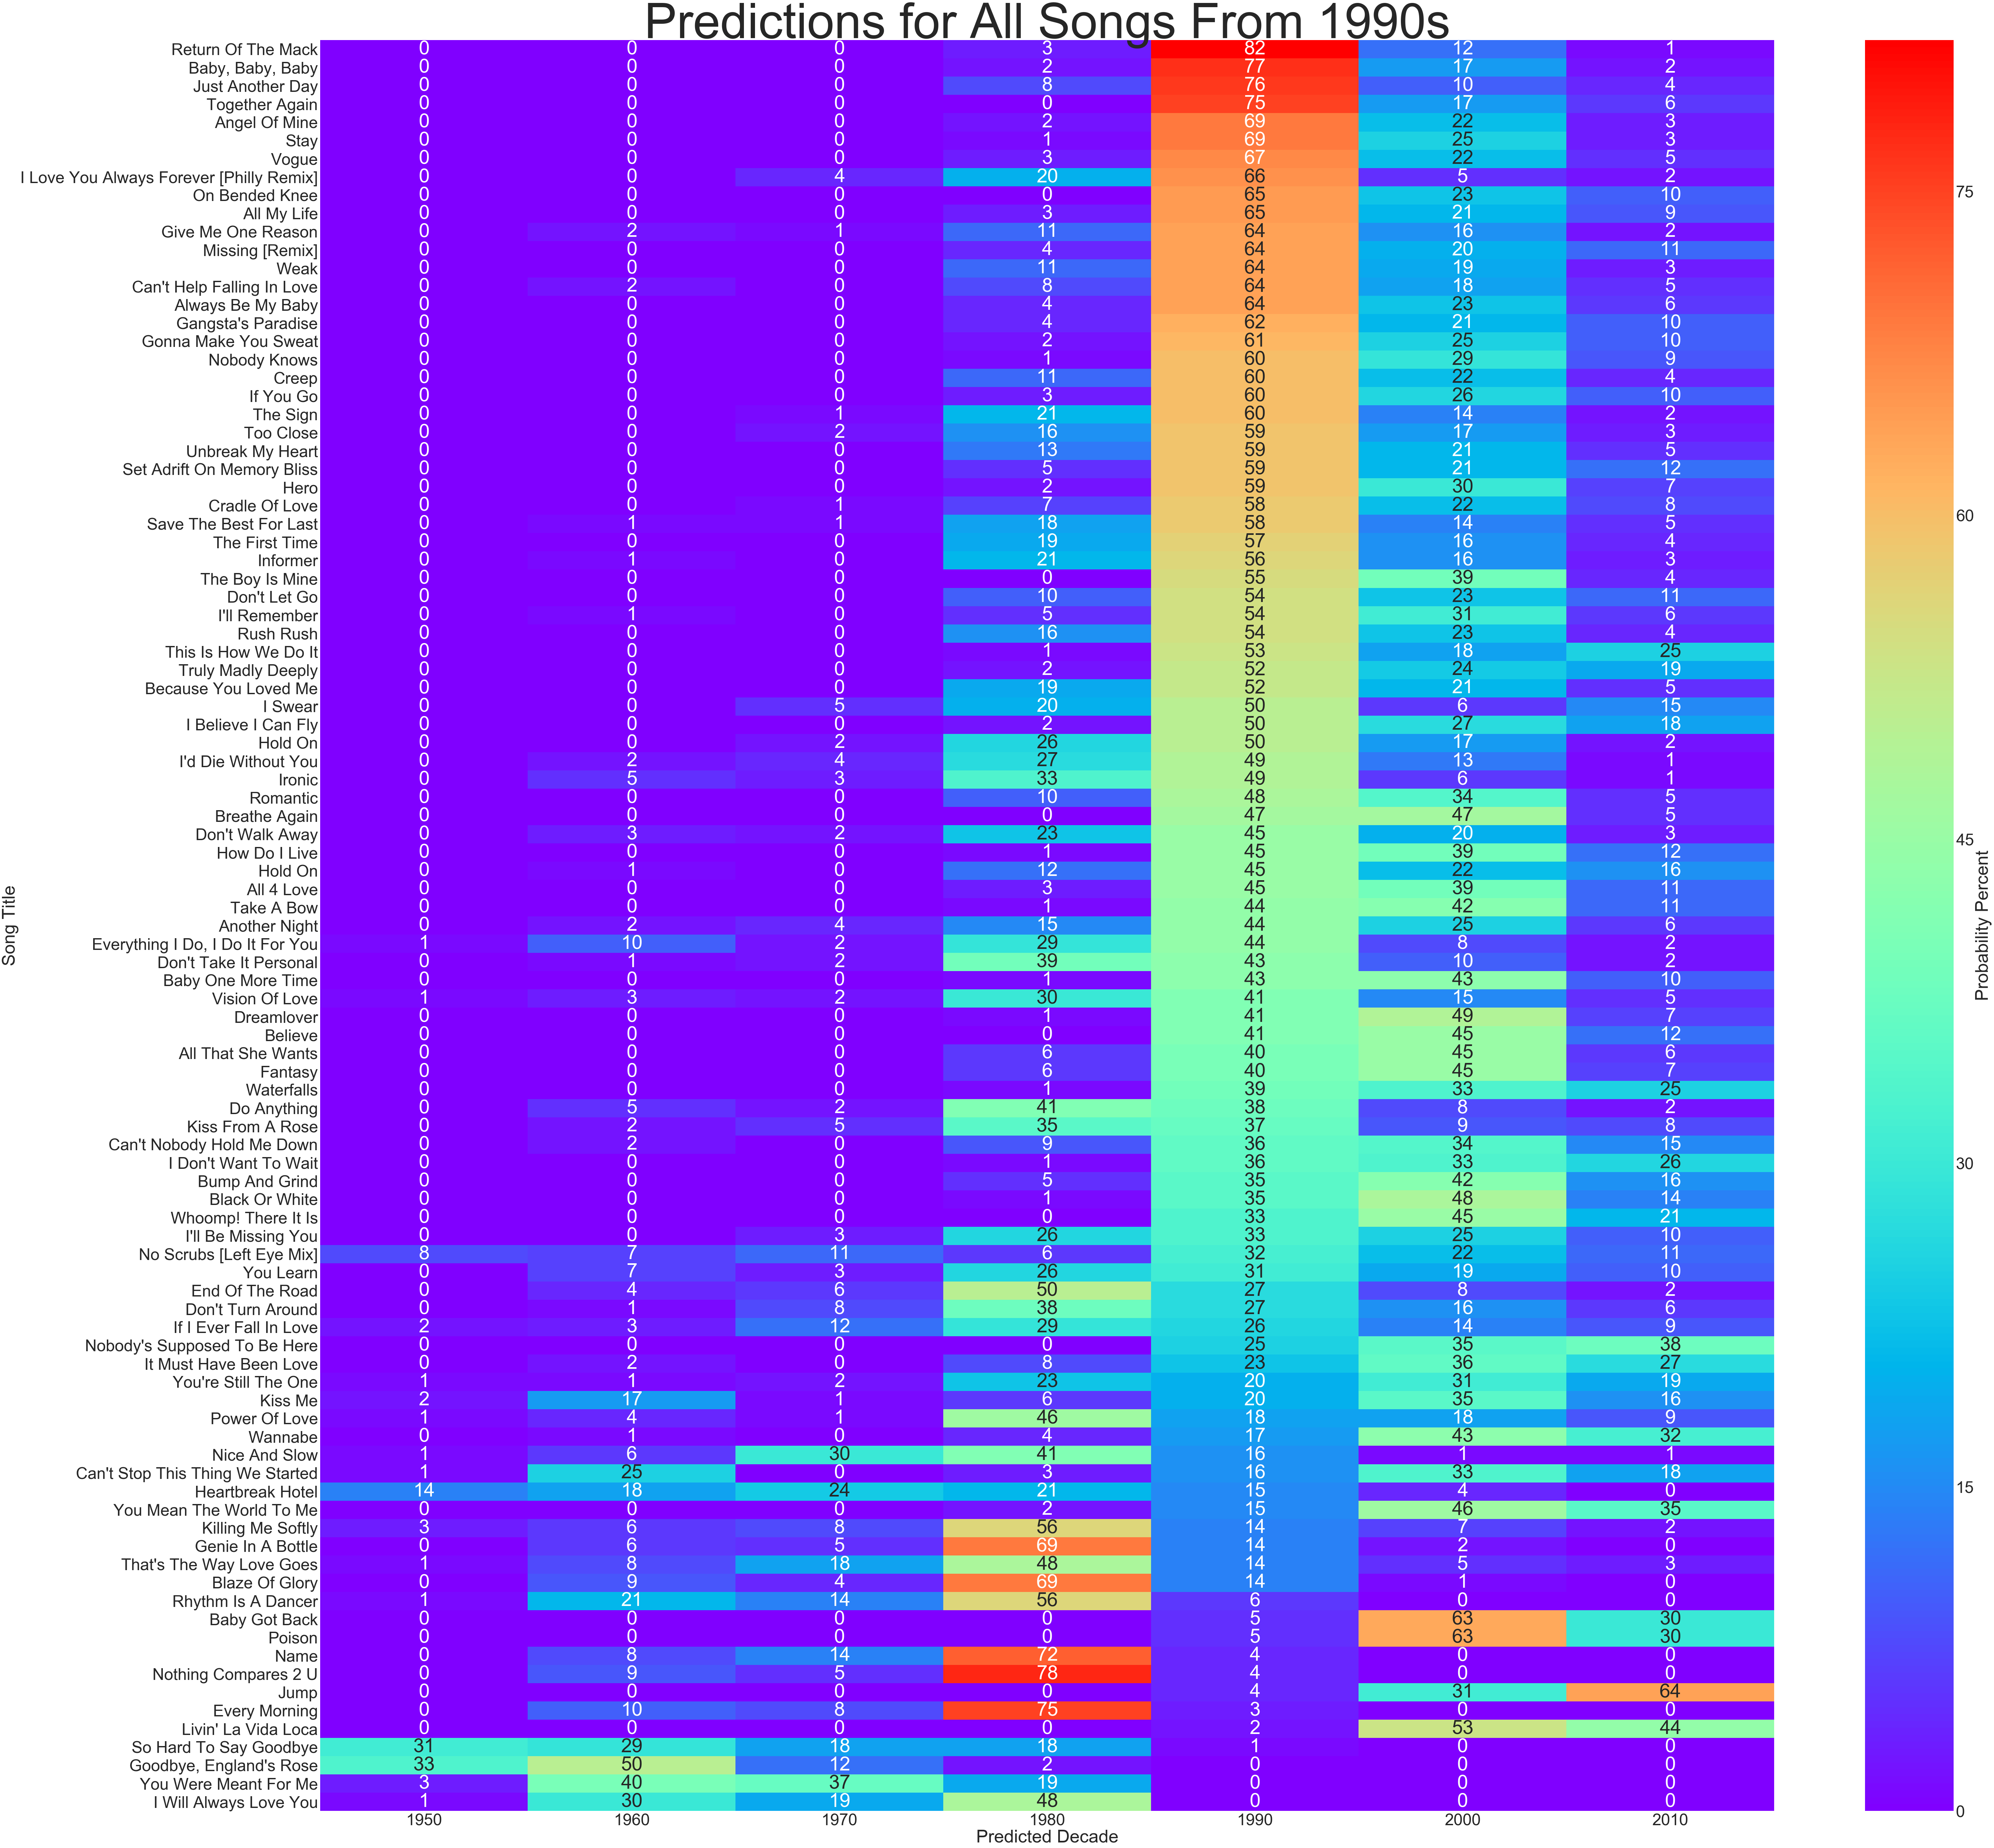

In [25]:
decade_index = 4
decade = decades[decade_index]
fig = plt.figure(figsize=(100, 100))
seaborn.set(font_scale=5)
songs_from_decade = music_files_test[Y_test_decade == decade]
songs_from_decade = [os.path.basename(song).split('_')[1] for song in songs_from_decade]
songs_from_decade = np.asarray(songs_from_decade)
probabilities_from_decade = (np.asarray(Y_predict_proba))[Y_test_decade == decade,:]
probabilities_from_decade = (probabilities_from_decade*100).astype(int)
sorting_probability = probabilities_from_decade[:,decade_index]
sorted_indices = np.argsort(-sorting_probability)
songs_sorted = songs_from_decade[sorted_indices]
probabilities_sorted = probabilities_from_decade[sorted_indices]

df_decade = pd.DataFrame(probabilities_sorted, index=songs_sorted, columns=decades)
heatmap_decade = seaborn.heatmap(df_decade,cmap=cm.rainbow,cbar_kws={'label': 'Probability Percent'}, annot=True, fmt="d")

heatmap_decade.set(xlabel='Predicted Decade', ylabel='Song Title')
heatmap_decade.set_title('Predictions for All Songs From '+str(decade)+'s', fontsize = 150)
heatmap_decade_fig = heatmap_decade.get_figure()
heatmap_decade_fig.savefig('Plot2_'+str(decade)+'s_Predictions.png')
plt.show()

Now, let's determine which songs the model was most confused about and which songs the model was most sure about.  I determine this by using the standard deviations of the probability arrays.  The arrays with smallest standard deviations are the ones where the probabilities for each class were more equal.  From the music clips, we can see that some misclassifications happen due to the short length of the clip.  For example, the clip of "Royals" by Lorde contains background harmonies that are similar to those of girl groups from the 1960s, so it is understandable that it would be misclassified as the 1960s.

You Can't Hurry Love
Diana Ross & The Supremes
1966


Royals
Lorde
2013


I Can't Stop Loving You
Ray Charles
1962


The Way You Move
Outkast Ft Sleepy Brown
2004


Boogie Oogie Oogie
A Taste Of Honey
1978


The Hills
The Weeknd
2015


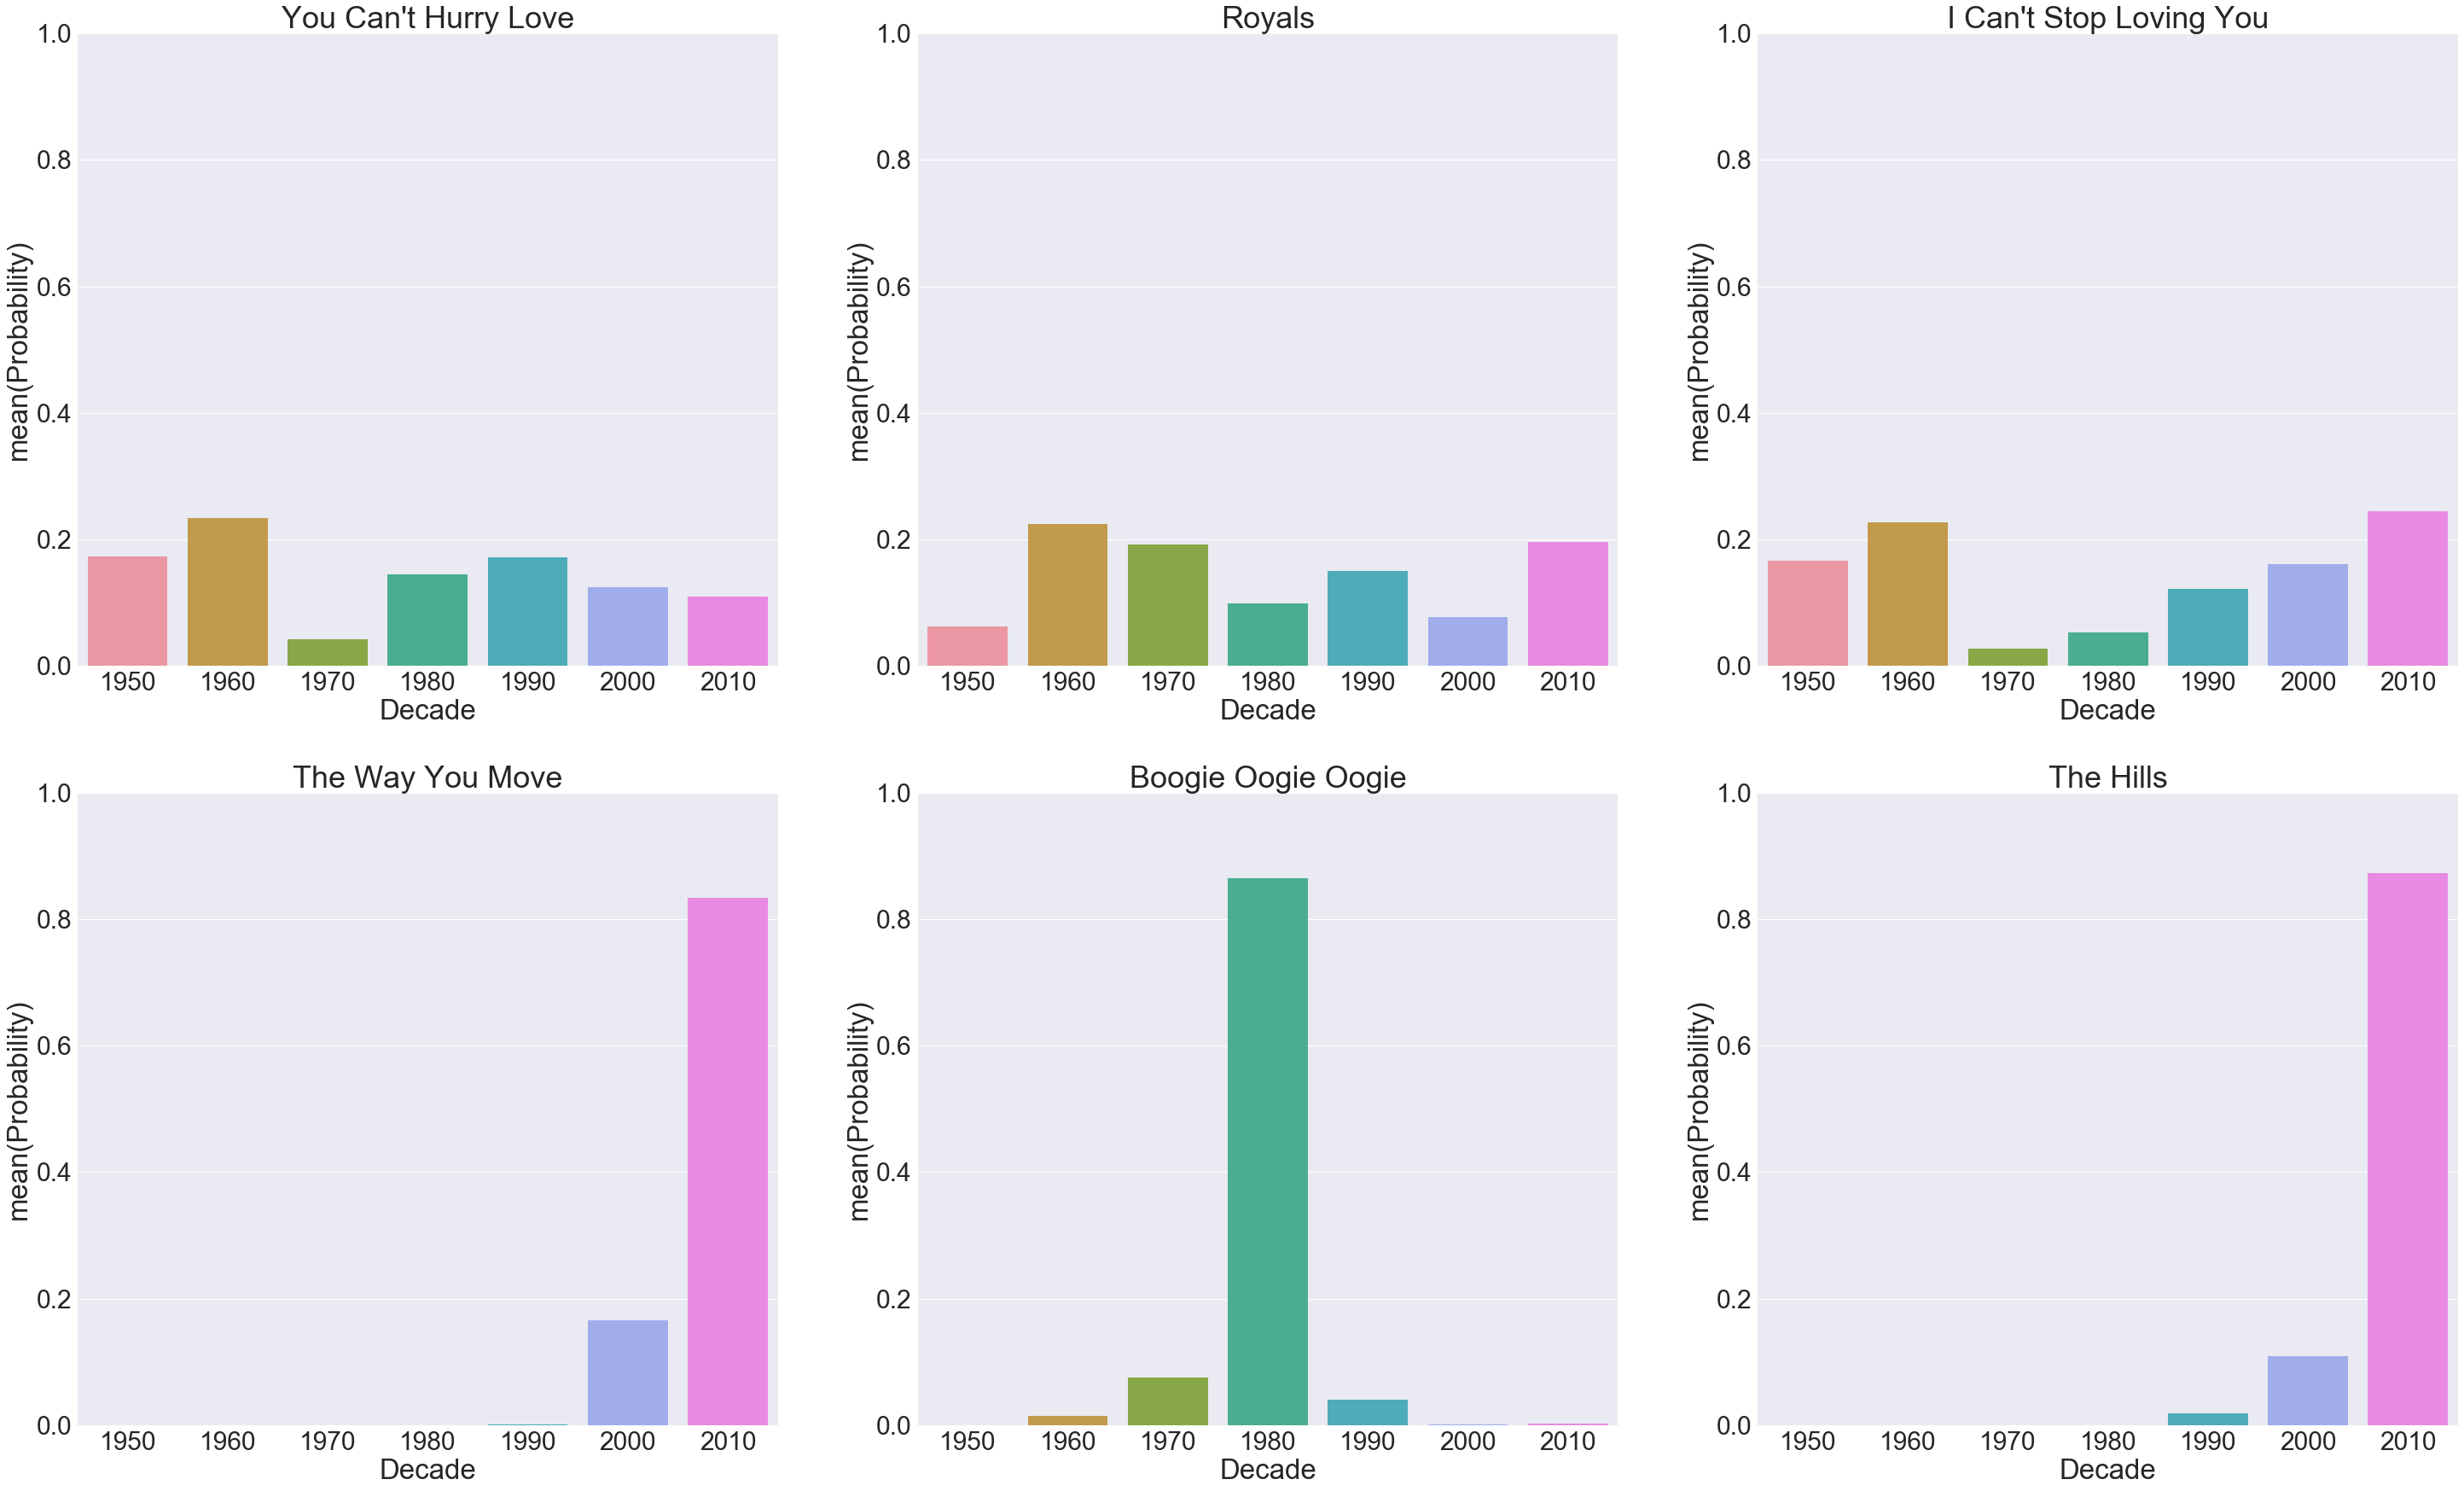

In [24]:
stdev = np.std(Y_predict_proba,axis=1)
sorted_indices = np.argsort(stdev)
songs_sorted_stdev = music_files_test[sorted_indices]
probabilities_sorted_stdev = Y_predict_proba[sorted_indices,:]
years_sorted = Y_test_decade[sorted_indices]
years_sorted

least_sure_songs = songs_sorted_stdev[:3].tolist()
least_sure_probabilities = probabilities_sorted_stdev[:3,:]
most_sure_songs = songs_sorted_stdev[-3:].tolist()
most_sure_probabilities = probabilities_sorted_stdev[-3:,:]

fig = plt.figure(figsize=(50, 30))
seaborn.set(font_scale=3)
for i,song in enumerate(least_sure_songs):
    print(os.path.basename(song).split('_')[1])
    print(os.path.basename(song).split('_')[2].split('.')[0])
    print(os.path.basename(os.path.dirname(song)))
    audio_time_series, sampling_rate = librosa.load(song)
    length = len(audio_time_series)
    middle_index = int(length/2)
    song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    ipd.display(ipd.Audio(song_middle, rate=sampling_rate))
    probability_list = least_sure_probabilities[i,:]
    dictionary = {'Decade':np.asarray(decades), 'Probability':np.asarray(probability_list)}
    df = pd.DataFrame()
    df = df.from_dict(dictionary)
    ax = fig.add_subplot(2,3,i+1)
    barplot = seaborn.barplot(x='Decade', y='Probability', data=df, ax=ax)
    axes = barplot.axes
    axes.set_ylim(0,1)
    axes.set_title(os.path.basename(song).split('_')[1])
    
for i,song in enumerate(most_sure_songs):
    print(os.path.basename(song).split('_')[1])
    print(os.path.basename(song).split('_')[2].split('.')[0])
    print(os.path.basename(os.path.dirname(song)))
    audio_time_series, sampling_rate = librosa.load(song)
    length = len(audio_time_series)
    middle_index = int(length/2)
    song_middle = audio_time_series[middle_index-50000:middle_index+50000]
    ipd.display(ipd.Audio(song_middle, rate=sampling_rate))
    probability_list = most_sure_probabilities[i,:]
    dictionary = {'Decade':np.asarray(decades), 'Probability':np.asarray(probability_list)}
    df = pd.DataFrame()
    df = df.from_dict(dictionary)
    ax = fig.add_subplot(2,3,i+4)
    barplot = seaborn.barplot(x='Decade', y='Probability', data=df)
    axes = barplot.axes
    axes.set_ylim(0,1)
    axes.set_title(os.path.basename(song).split('_')[1])
    
plt.show()

We can also uun a principal component analysis and t-SNE to see if the songs cluster naturally.  t-SNE is a method that maps higher dimensional data to a lower dimensional space while preserving local distances.

Explained variation per principal component (PCA): 0.772898137569
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5940 samples in 0.010s...
[t-SNE] Computed neighbors for 5940 samples in 0.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5940
[t-SNE] Computed conditional probabilities for sample 2000 / 5940
[t-SNE] Computed conditional probabilities for sample 3000 / 5940
[t-SNE] Computed conditional probabilities for sample 4000 / 5940
[t-SNE] Computed conditional probabilities for sample 5000 / 5940
[t-SNE] Computed conditional probabilities for sample 5940 / 5940
[t-SNE] Mean sigma: 0.273688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.636063
[t-SNE] Error after 5000 iterations: 1.839728


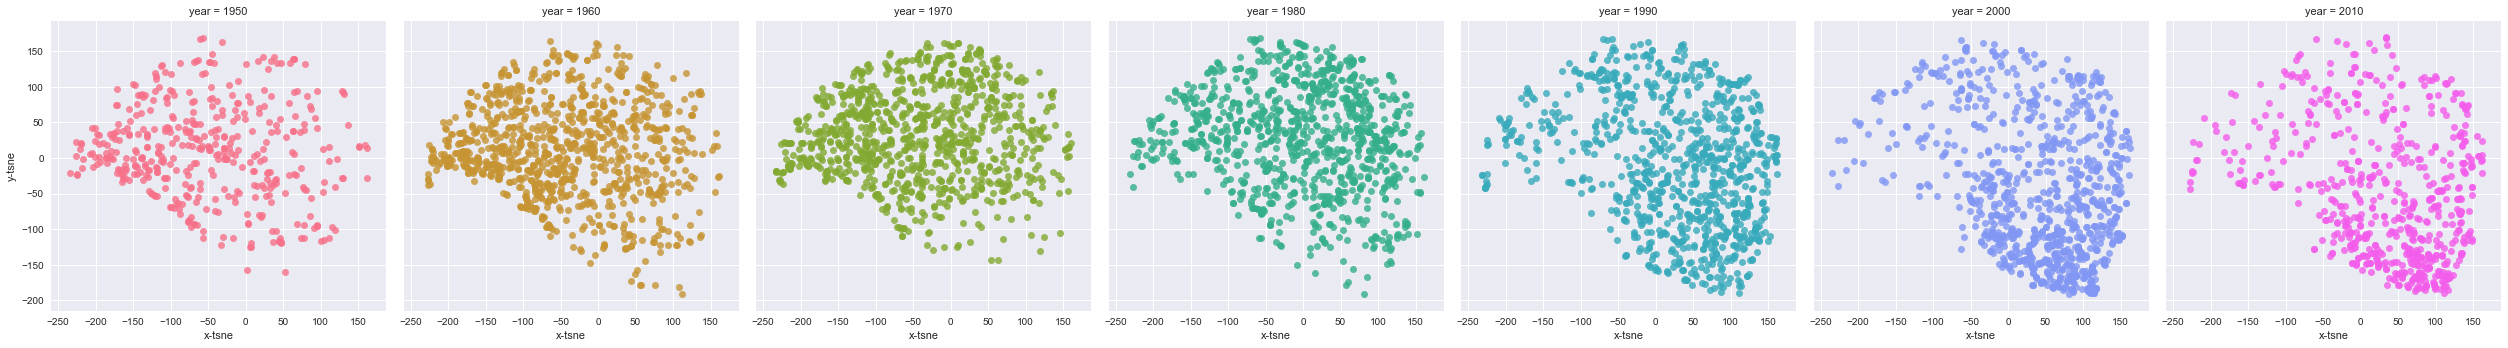

In [27]:
flat_X = np.squeeze(X[:,:,0])

pca = PCA(n_components=10)
pca_result = pca.fit_transform(flat_X)
pca_result.shape
print 'Explained variation per principal component (PCA): {}'.format(np.sum(pca.explained_variance_ratio_))

tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=5000)
tsne_results = tsne.fit_transform(pca_result)

df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['year'] = get_Y_decade(Y)

seaborn.set(font_scale=1)
seaborn.lmplot('x-tsne', 'y-tsne', df_tsne, hue='year', col='year', fit_reg=False)